In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import RK45, odeint, solve_ivp
from scipy.special import expit
import math
from tqdm import tqdm
plt.style.use(['science','notebook','grid'])
from scipy.fft import fft, fftfreq, ifft, fftshift, ifftshift, ifft
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

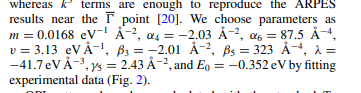

In [2]:
Par = np.array([0.0168, -2.03, 87.5, 3.13, -2.01, 323, -41.7, 2.43, -0.352])

In [3]:
N = 800; #16
om = -0.01;
k_spacex, k_spacey = np.mgrid[-1.5:1.5:N*1j,-1.5:1.5:N*1j]
#k_spacex1, k_spacey1 = np.ogrid[-1.5:1.5:500j,-1.5:1.5:500j]
test = [k_spacex, k_spacey]
var = np.zeros([len(k_spacex),len(k_spacex)])



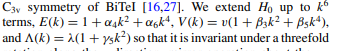

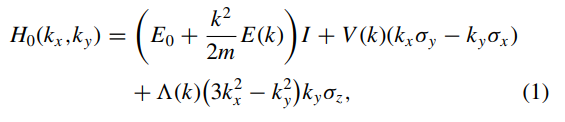

In [4]:
σx = np.array([[0, 1],[1, 0]]); σy = np.array([[0, -1j],[1j, 0]]); σz = np.array([[1, 0],[0, -1]])

def H(kr, p = Par):
    k_x, k_y = kr
    m, α4, α6, v, β3, β5, λ, γ5, E0 = p
    kp = k_y+1j*k_x; km = k_y-1j*k_x;
    ksq = k_x**2+k_y**2
    Ek = 1+α4*ksq+α6*ksq**2; Vk = v*(1+β3*ksq+β5*ksq**2); Λ = λ*(1+γ5*ksq)
    return (E0+ksq/(2*m)*Ek)*np.eye(2)+Vk*(k_x*σy-k_y*σx)+Λ*(3*k_x**2-k_y**2)*k_y*σz

print(H([0.2,1.1]))

[[ 5230.58049637  +0.j      -1732.431525  -314.98755j]
 [-1732.431525  +314.98755j  4826.84422387  +0.j     ]]


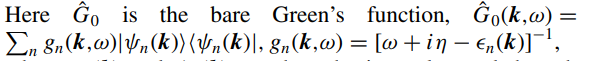

In [5]:
from numpy import linalg as LA
import scipy.linalg as la
η = 0.01
def G0(k, ω = om):
    kx, ky = k
    Ham = H(k); 
    λ, v = LA.eig(Ham)
    summ = np.zeros([2,2], dtype = 'complex')
    for n in range(len(λ)):
        g = np.power(ω+1j*0.01-λ[n], -1)
        ψ = v[:,n]
        summ = summ+g*np.array([[ψ[0]*ψ[0].conj(),ψ[1].conj()*ψ[0]],[ψ[0].conj()*ψ[1],ψ[1].conj()*ψ[1]]])
    return summ
x = G0([1,1])


In [6]:
length = 0.6
k_spacex3, k_spacey3 = np.mgrid[-length:length:N*1j,-length:length:N*1j]

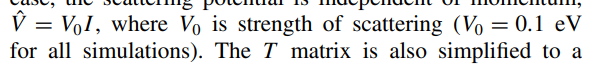

(scalar)

In [7]:
V = 0.1*σz
print(V)

[[ 0.1  0. ]
 [ 0.  -0.1]]


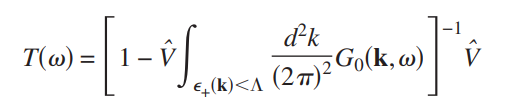

(Momentum-independent)

In [8]:
from numpy.linalg import inv
kx = np.linspace(-length,length,N)
G0Mp = np.zeros([N,N,2,2], dtype = 'complex')
for i in tqdm(range(N), desc="G0-Matrix"):
        for j in range(N):
            G0Mp[i,j] = G0([kx[i], kx[j] ], om)
# def T(ω = om):
#     summm = np.zeros([2,2])
#     for i in tqdm(range(N), desc="T-Matrix"):
#         for j in range(N):
#             summm = summm + G0Mp[i,j]
#     print(summm)
#     return np.dot(inv(np.eye(2)-np.dot(V, summm/N)), V)

G0-Matrix: 100%|██████████| 800/800 [01:04<00:00, 12.43it/s]


In [9]:
def T(ω = om):
    summm = np.zeros([2,2])

    for i in tqdm(range(N), desc="T-Matrix"):
        for j in range(N):
            summm = summm + G0Mp[i,j]
            

    return np.matmul(inv(np.eye(2)-np.matmul(V, summm/N**2)), V)

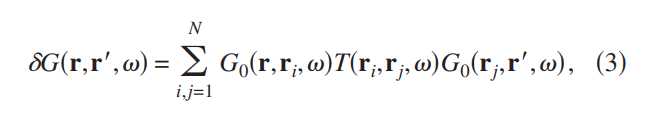
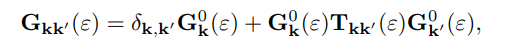

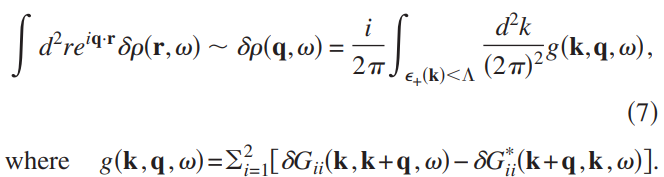

In [10]:
T1 = T(om) #outside of function speeds up
print(T1)

T-Matrix: 100%|██████████| 800/800 [00:00<00:00, 2110.90it/s]

[[ 9.70067702e-02-4.25203780e-03j -1.11598348e-18+7.94179433e-19j]
 [ 3.18501541e-20-1.44936660e-18j -1.02752196e-01-4.77174524e-03j]]


In [11]:
sol = np.zeros((N,N))

In [12]:
G0Mm = np.zeros([N,N,2,2], dtype = 'complex')
for i in tqdm(range(N), desc="G0-Matrix"):
        for j in range(N):
            G0Mm[i,j] = G0([-1*kx[i], -1*kx[j] ], om)
            

G0-Matrix: 100%|██████████| 800/800 [01:07<00:00, 11.81it/s]


In [13]:
G0Mpconj = np.zeros([N,N,2,2], dtype = 'complex')
G0Mmconj = np.zeros([N,N,2,2], dtype = 'complex')

for i in tqdm(range(N), desc="G0-Matrix HT"):
        for j in range(N):
            G0Mpconj[i,j] = G0Mp[i,j].conj().T
            
for i in tqdm(range(N), desc="G0-Matrix HT"):
        for j in range(N):
            G0Mmconj[i,j] = G0Mm[i,j].conj().T


G0-Matrix HT: 100%|██████████| 800/800 [00:01<00:00, 780.80it/s]


In [14]:
#print(G0M[:,:,0,0])
def DOS(w = om):
    fact = 1j/(2*np.pi)
    res = np.zeros([N,N], dtype = 'complex')
    T2 = T1.conj().T
    for m in range(2):
        for n in range(2):
            for j in tqdm(range(2), desc="G0-Matrix"):
                Gp1 = (np.fft.fft2(fftshift(G0Mp[:,:,n,j])))
                Gm1 = (np.fft.fft2(fftshift(G0Mm[:,:,j,m])))
                G1 = ifftshift(np.fft.ifft2((((Gp1)*(Gm1)))))
                Gp2 = (np.fft.fft2(fftshift(G0Mmconj[:,:,n,j])))
                Gm2 = (np.fft.fft2(fftshift(G0Mpconj[:,:,j,m])))
                G2 = ifftshift(np.fft.ifft2(((Gp2*Gm2))))
                res = res+T1[m,n]*(G1)-(T2[m,n]*(G2))
            
    
    sol = (np.abs((fact*res)))
    return sol

In [15]:
sol = DOS()
print(sol)

G0-Matrix: 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

[[16.50828806 16.51123769 16.51615383 ... 16.51123769 16.50828806
  16.50730486]
 [16.51207288 16.51502377 16.51994202 ... 16.51502377 16.51207288
  16.51108926]
 [16.51838102 16.52133402 16.52625579 ... 16.52133402 16.51838102
  16.5173967 ]
 ...
 [16.51207288 16.51502377 16.51994202 ... 16.51502377 16.51207288
  16.51108926]
 [16.50828806 16.51123769 16.51615383 ... 16.51123769 16.50828806
  16.50730486]
 [16.50702647 16.50997567 16.51489111 ... 16.50997567 16.50702647
  16.50604341]]


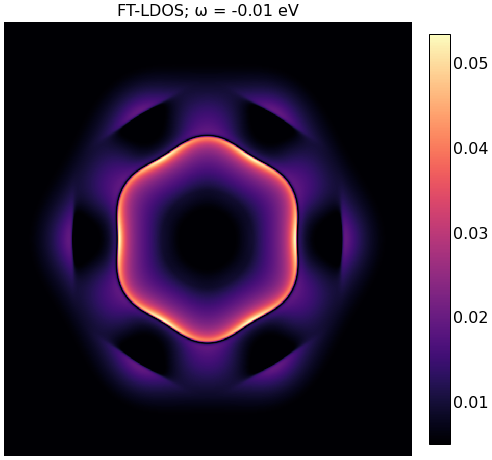

In [16]:
plt.figure(figsize=(8,8))
plt.pcolormesh(k_spacex3/length,k_spacey3/length, sol/N**2*10, cmap = "magma", shading = 'auto', vmin = 0.005) #,vmin = 1500/5000)
plt.title("FT-LDOS; ω = -0.01 eV")
plt.axis('off')

plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('Magnetic QPI 800 V eq T GOOD', bbox_inches='tight')
plt.show()

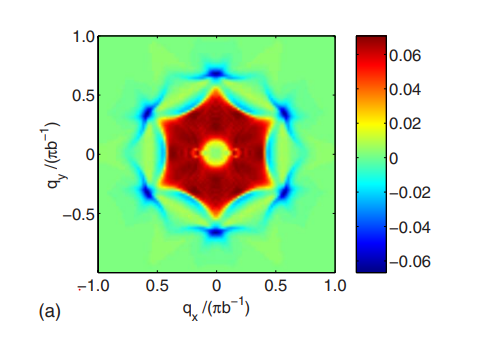